In [ ]:
! pip install mpire
! pip install Levenshtein

In [ ]:
# For Google Colab
# (https://stackoverflow.com/questions/63329657/python-3-7-error-unsupported-pickle-protocol-5)
!pip3 install pickle5
import pickle5 as pickle

# For local Jupyter
# import pickle

ФИО: Усцов Артем Алексеевич

In [ ]:
from typing import List
import torch
import pickle5 as pickle
import math
from collections import defaultdict
import numpy as np
from tqdm.auto import tqdm
import re
from matplotlib import pyplot as plt

# будем использовать mpire для ускорения
# на некоторых системах есть проблема с кол-вом открываемвых
# файловы дескрипторов, поэтому разрешим нашему процессу
# создавать их в большЕм количестве

# from mpire import WorkerPool
import resource
soft, hard = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (hard, hard))

In [ ]:
!pip install -U --no-cache-dir gdown --pre

In [ ]:
!gdown https://drive.google.com/uc?id=1nCJSQAf9a8mmh2Nsvlj92FPbx2fr8AAJ

Downloading...
From: https://drive.google.com/uc?id=1nCJSQAf9a8mmh2Nsvlj92FPbx2fr8AAJ
To: /content/test_data.pt
100% 422M/422M [00:11<00:00, 35.8MB/s]


In [ ]:
!gdown https://drive.google.com/uc?id=1diT8BdaoY2YfPsELZv6X-ikueGVs60-C

Downloading...
From: https://drive.google.com/uc?id=1diT8BdaoY2YfPsELZv6X-ikueGVs60-C
To: /content/vocab.pkl
100% 296/296 [00:00<00:00, 350kB/s]


In [ ]:
TEST_CTC_DATASET_PATH = './test_data.pt'
VOCAB_PKL_PATH = './vocab.pkl'

In [ ]:
dataset = torch.load(TEST_CTC_DATASET_PATH)
with open(VOCAB_PKL_PATH, 'rb') as fin:
    vocab_dict = pickle.load(fin)

In [ ]:
dataset[0][0].shape

torch.Size([1, 291, 39])

In [ ]:
len(vocab_dict)

39

# Часть 1. Метрики.

In [ ]:
# поможем себе с расстоянием Левенштейна
import Levenshtein

# Будем использовать эту функцию для нормализации текстов перед замером CER / WER
ALLOWED_SYMBOLS = re.compile(r"(^[a-zа-я\s]+$)")
def normalize_text(text: str) -> str:
    """
    В датасетах, иногда встречается '-', 'ё', апострофы и большие буквы. А мы хотим, чтобы:
        WER("Ростов-на-дону", "ростов на дону") == 0
        WER("It's", "it s") == 0
        WER("ёлки палки", "елки палки") == 0
    Поэтому заменяем в target'ах 'ё' на 'е', а '-' на ' ' и т. д.
    Кроме того на всякий случай удаляем лишние пробелы.
    И проверяем что в получившейся строке только допустимые символы.
    """
    assert isinstance(text, str)
    text = text.lower().strip().replace("ё", "е")
    text = re.sub(r"\W+", " ", text)
    text = re.sub(r"\s+", " ", text)
    text = text.strip().split(" ")
    text = " ".join(word for word in text if len(word) > 0)
    assert (text == "") or ALLOWED_SYMBOLS.match(text)
    return text

def wer(ground_truth: str, predicted: str) -> float:
    ground_truth = ground_truth.split(' ')
    predicted = predicted.split(' ')
    return Levenshtein.distance(ground_truth, predicted)

def cer(ground_truth: str, predicted: str) -> float:
    return Levenshtein.distance(ground_truth, predicted)

# Функции для расчета relative CER / WER
# В функции нужно подавать строки обработанные методом normalize_text
def relative_cer(ground_truth: str, predicted: str) -> float:
    assert isinstance(ground_truth, str)
    assert isinstance(predicted, str)
    return min(1, cer(ground_truth, predicted) / (len(ground_truth) + 1e-10))

def relative_wer(ground_truth: str, predicted: str) -> float:
    assert isinstance(ground_truth, str)
    assert isinstance(predicted, str)
    gt_len = ground_truth.count(" ") + 1
    return min(1, wer(ground_truth, predicted) / (gt_len + 1e-10))

# Функции для расчета ORACLE relative CER / WER - тут мы выбираем лучшую гипотезу из beam'a
# В функции нужно подавать строки обработанные методом normalize_text
def oracle_relative_cer(ground_truth: str, predicted: List[str]) -> float:
    return min(relative_cer(normalize_text(ground_truth), normalize_text(hypo)) for hypo in predicted)

def oracle_relative_wer(ground_truth: str, predicted: List[str]) -> float:
    return min(relative_wer(normalize_text(ground_truth), normalize_text(hypo)) for hypo in predicted)

In [ ]:
# Тесты для проверки правильности реализации cer/wer 
assert(cer(normalize_text("алёнка родила девчёнку"), normalize_text("аленка радила девченку Инну")) == 6)
assert(wer(normalize_text("алёнка родила девчёнку"), normalize_text("аленка радила девченку Инну")) == 2)

assert(cer(normalize_text(""), normalize_text("")) == 0)
assert(wer(normalize_text(""), normalize_text("")) == 0)

assert(cer(normalize_text("Ростов-на-дону"), normalize_text("ростов на дону")) == 0)
assert(wer(normalize_text("Ростов-на-дону"), normalize_text("ростов на дону")) == 0)

assert(cer(normalize_text("It's"), normalize_text("it s")) == 0)
assert(wer(normalize_text("It's"), normalize_text("it s")) == 0)

# Часть 2. CTC декодинг.

In [ ]:
from math import log

In [ ]:
class CTCDecoder:
    
    def __init__(self, vocab_dict):
        self.vocab = vocab_dict
        
        # Id специальных токенов в словаре
        self.blank_id = 0
        self.bos_id = 1
        self.eos_id = 2
        self.unk_id = 3
        self.word_sep_id = 4 
        # word_sep_id должен быть заменен на пробел при декодировании
        # и не забудьте удалить пробелы в конце строки!

    def process_symbols(self, symbols:list):
      str = ''
      for i in range(len(symbols)-1):
        if symbols[i] == 0:
          continue
        if symbols[i+1] == symbols[i]:
          continue
        if symbols[i] == 4:
          str += ' '
          continue
        str += self.vocab[symbols[i]]

      return str
        
    def argmax_decode(self, ctc_logits: torch.tensor) -> str:
        '''
        ctc_logits - ctc-матрица логитов размерности [TIME, VOCAB]
        '''
        assert ctc_logits.shape[1] == len(self.vocab)
        prob = torch.nn.functional.softmax(ctc_logits, dim=-1)
        ids = prob.max(-1)[1]
        return self.process_symbols(ids.numpy())
    
    def beam_search_decode(self, ctc_logits: torch.tensor, beam_size: int=16) -> List[str]:
        '''
        ctc_logits - ctc-матрица логитов размерности [TIME, VOCAB]
        beam_size - размер луча
        '''
        # Здесь должен быть ваш код, который будет оцениваться
        sequences = [[list(), 0.0]]
        ctc_logits = torch.nn.functional.softmax(ctc_logits, dim=-1)
        ctc_logits = ctc_logits.numpy()
	      # walk over each step in sequence
        for row in ctc_logits:
          all_candidates = list()
		      # expand each current candidate
          for i in range(len(sequences)):
            seq, score = sequences[i]
            for j in range(len(row)):
              candidate = [seq + [j], score - log(row[j])]
              all_candidates.append(candidate)
	        # order all candidates by score
          ordered = sorted(all_candidates, key=lambda tup:tup[1])
		      # select k best
          sequences = ordered[:beam_size]
        return [self.process_symbols(sequence[0]) for sequence in sequences]

In [ ]:
ctc_decoder = CTCDecoder(vocab_dict)

## <font color='red'>Внимание!</font> Далее ВЕЗДЕ используем только relative версии рассчета CER / WER и их oracle версии.

### Argmax декодинг.

In [ ]:
# Рассчитаем усредненный по всему датасету relative CER / WER для ARGMAX варианта декодирования
cer_argmax = 0
wer_argmax = 0

for i in range(len(dataset)):
  predict = ctc_decoder.argmax_decode(dataset[i][0][0])
  ground_truth = dataset[i][1]
  cer_argmax += relative_cer(normalize_text(ground_truth), normalize_text(predict))
  wer_argmax += relative_wer(normalize_text(ground_truth), normalize_text(predict))

cer_argmax /= len(dataset)
wer_argmax /= len(dataset)


print(f"Mean CER in argmax decoding : {cer_argmax}")
print(f"Mean WER in argmax decoding : {wer_argmax}")

Mean CER in argmax decoding : 0.040561903129852875
Mean WER in argmax decoding : 0.15567387844386432


## Вопрос №1: Как соотносятся WER и CER в задаче ASR?

## Ответ: 
### - mean cer получился в разы меньше. Так получилось из-за того, что (слов с ошибкой)/(все слова) намного больше чем (символы с ошибкой) / (все символы), так как даже ошибка в одном символе сделает нерелевантным слово целиком   

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
forks_num = 50
def beam_search_errors(fork_id):
  cer_bs1 = 0
  wer_bs1 = 0

  left = 0
  right = len(dataset)
  for i in tqdm(range(left, right)):
    predict = ctc_decoder.beam_search_decode(dataset[i][0][0], beam_size=1)
    ground_truth = dataset[i][1]
    cer_bs1 += oracle_relative_cer(ground_truth, predict)
    wer_bs1 += oracle_relative_wer(ground_truth, predict)
  return cer_bs1, wer_bs1

In [ ]:
# Рассчитаем усредненный по всему датасету relative CER / WER для BEAM_SEARCH варианта декодирования
# Для рассчета используем beam_size = 1 !!!
# Hint : стоит использовать mpire для ускорения
cer_bs1 = 0
wer_bs1 = 0

results = [beam_search_errors(0)]

cer_bs1 = sum([result[0] for result in results]) / len(dataset)
wer_bs1 = sum([result[1] for result in results]) / len(dataset)

print(f"CER in bs decoding : {cer_bs1}")
print(f"WER in bs decoding : {wer_bs1}")

  0%|          | 0/9630 [00:00<?, ?it/s]

CER in bs decoding : 0.040561903129852875
WER in bs decoding : 0.15567387844386432


In [ ]:
# Проверим, что мы нигде не ошиблись в написании кода beam_search_decode
np.testing.assert_almost_equal(cer_argmax, cer_bs1, decimal=4)
np.testing.assert_almost_equal(wer_argmax, wer_bs1, decimal=4)

In [ ]:
forks_num = 200
def beam_search_errors_top1(fork_id):
  oracle_cer_bs1 = 0
  oracle_wer_bs1 = 0
  top1_cer = 0
  top1_wer = 0
  left = int(len(dataset)*fork_id/forks_num)
  right = int(len(dataset)*(fork_id+1)/forks_num)

  left = 0
  right = len(dataset)
  for i in tqdm(range(left, right)):
    predict = ctc_decoder.beam_search_decode(dataset[i][0][0], beam_size=beam_size)
    ground_truth = dataset[i][1]
    top1_cer += relative_cer(ground_truth, predict[0])
    top1_wer += relative_wer(ground_truth, predict[0])
    oracle_cer_bs1 += oracle_relative_cer(ground_truth, predict)
    oracle_wer_bs1 += oracle_relative_wer(ground_truth, predict)
  return oracle_cer_bs1, oracle_wer_bs1, top1_cer, top1_wer

In [ ]:
# Ок, значит все хорошо и можно приступить к построению графиков
# зависимости усредненного CER / WER + oracle от beam_size.

# Для этого будем использовать beam_size = [4, 8, 16, 32].
# Заполним словарик усредненных по датасету relative wer / cer наиболее вероятной гипотезы - top1_wer, top1_cer.
# Так же добавим в словарик relative oracle wer / cer - orcale_wer, oracle_cer
graph_results = {'oracle_wer':[], 'oracle_cer':[], 'top1_wer':[], 'top1_cer': []}
beam_sizes = [4, 8, 16, 32]
for beam_size in beam_sizes:
    top1_wer, top1_cer, oracle_wer, oracle_cer = 0, 0, 0, 0

    results = [beam_search_errors_top1(0)]

    oracle_cer = sum([result[0] for result in results]) / len(dataset)
    oracle_wer = sum([result[1] for result in results]) / len(dataset)
    top1_cer = sum([result[2] for result in results]) / len(dataset)
    top1_wer = sum([result[3] for result in results]) / len(dataset)
    
    # Здесь должен быть ваш код, который будет оцениваться
    graph_results['top1_cer'].append(top1_cer)
    graph_results['top1_wer'].append(top1_wer)
    graph_results['oracle_cer'].append(oracle_cer)
    graph_results['oracle_wer'].append(oracle_wer)

  0%|          | 0/9630 [00:00<?, ?it/s]

  0%|          | 0/9630 [00:00<?, ?it/s]

  0%|          | 0/9630 [00:00<?, ?it/s]

  0%|          | 0/9630 [00:00<?, ?it/s]

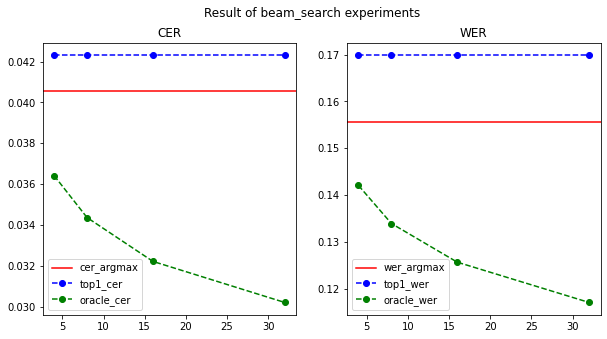

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Result of beam_search experiments')

axs[0].axhline(y = cer_argmax, color = 'r', linestyle = '-', label='cer_argmax')
axs[0].plot(beam_sizes, graph_results['top1_cer'], '--bo', label='top1_cer') 
axs[0].plot(beam_sizes, graph_results['oracle_cer'], '--go', label='oracle_cer')
axs[0].set_title('CER')
axs[0].legend()

axs[1].axhline(y = wer_argmax, color = 'r', linestyle = '-', label='wer_argmax')
axs[1].plot(beam_sizes, graph_results['top1_wer'], '--bo', label='top1_wer')
axs[1].plot(beam_sizes, graph_results['oracle_wer'], '--go', label='oracle_wer')
axs[1].set_title('WER')
axs[1].legend()

## Вопрос №2: 
## - Сделайте выводы относительно поведения CER / WER при увеличении размера beam_size? 
## - Как соотносятся значения relative CER / WER и ORACLE варианты в beam_search ? 
## - Почему они так соотносятся ? 
## - Как можно улучшить beam search ?